#**<center>Machine Learning Finance - ENSAE</center>**

 **<center>Eleonore Blanchard, Jing Tan, Yannick Ly, Inès Deguy</center>** 

#Importation

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

#Reccurent Reinforcement Learning


When an economic agent invests in financial markets, he has to make decisions under uncertainty. In such a context, his task consists in coping with financial risk in order to maximize some predetermined measure of profitability. A wide-spread class of tools which are used to support such risky decisions is the one of the financial trading systems (FTSs).

Alternative approaches to the standard building of FTSs have been proposed both in the operative literature and in the academic ones. In this paper we consider the ones which exploit artificial neural network (ANN) methodologies based on recurrent reinforcement learnings.
In general terms, these approaches consist:

*   In specifying a trading policy based on some predetermined investor’s measure of profitability (we will choose the reciprocal of the returns weighted direction symmetry index).
*   In setting the frame and the parameters of the FTS while using it.


## Data Importation

We apply our FTS to 4 of the major world financial market indices: CAC 40, Dow Jones Industrial Average, S&P 500 and NASDAQ Composite. In detail, we consider close daily data from January 1, 1990, to May 16, 2020.


In [0]:
spx = pd.read_csv("GSPC.csv")
cac = pd.read_csv("FCHI.csv")
dj = pd.read_csv("DJI.csv")
nasdaq = pd.read_csv("IXIC.csv")

In [0]:
training_beginning=spx[spx['Date']=='2015-12-31']
training_end=spx[spx['Date']=='2015-12-31']
test_beginning=spx[spx['Date']=='2016-01-01']
test_end=spx[spx['Date']=='2020-01-01']

In [0]:
spx=spx['Close'].dropna()
cac=cac['Close'].dropna()
dj=dj['Close'].dropna()
nasdaq=nasdaq['Close'].dropna()

We consider a net reward formulated in terms of rate of return instead of price.

In [0]:
spx_r=spx[1:] / spx[:-1].values- 1
cac_r=cac[1:] / cac[:-1].values- 1
dj_r=dj[1:] / dj[:-1].values- 1
nasdaq_r=nasdaq[1:] / nasdaq[:-1].values- 1

##Model

###1. The Financial Trading System

In this section, we describe our discrete-time trading strategy and we obtain all the new learning relationships related to the considered measure of profitability.


**Trading strategy function**

We will use the following function `positions` to determine our position, $F$, at time $t$:

<center>$F_{t}=tanh(θ^Tx_{t})$</center>

This function will generate a value between -1 and 1, which will tell us what percentage of the portfolio should buy the asset. $θ$ will be the parameters we will optimize using gradient ascent, and $x_{t}$ will be the input vector at time $t$.  We will assign the input vector as :
<center>$x_{t}= [1, r_{t - M}, … , r_t, F_{t - 1}]$</center>

where $r_{t}$  is the change in value between the asset at time $t$ and $t-1$, and $M$ is the number of time series inputs. This means that at every time step, the model will be fed its last position and a series of historical price changes that it can use to calculate its next position. 

In [0]:
def positions(x, theta):
    M = len(theta) - 2
    T = len(x)
    y = np.zeros(T)
    F=np.zeros(T)
    for t in range(M, T):
        xt = np.concatenate([[1], x[t - M:t], [F[t - 1]]])
        y[t] = np.tanh(np.dot(theta, xt))
        
        if y[t]>0:
            F[t]=1
        elif y[t]==0:
            F[t]=F[t-1]
        else:
            F[t]=-1
    return y,F

**Net Reward**

Now that we know what our position will be at each time step, we can calculate in the function `rewards` our returns $R$ at each time step using the following formula:

<center>$R_{t}=μ[F_{t-1}r_{t}- δ|F_{t}-F_{t-1}|]$</center>

*   $μ$ : The amount of capital to invest.
*   $r_{t}$ : The geometric rate of return at time $t$.
*   $δ$ : The per cent transaction cost related to the portfolio quota to trade.


In [0]:
def rewards(F, x, delta,mu):
    T = len(x)
    rets =mu* (F[0:T - 1] * x[1:T] - delta * np.abs(F[1:T] - F[0:T - 1]))
    return np.concatenate([[0], rets])

**Reciprocal of the returns weighted direction symmetry index**

Finally, we define in `rrwds` the reciprocal of the returns weighted directional symmetry measure.
This ratio is given at each time $t$ by the ratio between the cumulative positive rewards and the cumulative negative rewards.

In [0]:
def rrwds(A_last,B_last,R,eta):

    if R>0:
        A=eta*R+(1-eta)*A_last
        B=B_last
    else:
        A=A_last
        B=-eta*R+(1-eta)*B_last

    return A/B,A,B

###2. The Drawdown-like Phenomenon Management

Our FTS should be able to minimize large losses, and in case they occur it should be able to guarantee the continuation of the trading.

In order to guarantee the continuation of the financial trading in case a large loss occurs, we utilize as amount of capital to invest $μ+μ_{0}$  where:

<center>$μ_{0}=min_{0<t<t_{off}} [R_{t}:R_{t}<0 ∧ CR_{t}<0 ∧ sign(F_{t}F_{t-1})=-1] $</center>
 
$μ_{0}$  is the absolute value of the largest loss (associated to the occurrence that the net cumulative reward is negative and the trading strategy is changed) happened during the initial part of the first time sub-period. 

In [0]:
def drawdown(trading_off,t,x,theta):
    x_trading_off=x[t:trading_off+t]
    F,Fsign = positions(x_trading_off, theta)
    R=rewards(F,x_trading_off,delta,mu)

    l_drawdown=[]
    for i in range(t,trading_off):
        CR=sum(R[:i])
        if (Fsign[i]*Fsign[i-1]<0) and (R[i]<0) and (CR<0):
            l_drawdown.append(R[i])
    
    if l_drawdown:
        return min(l_drawdown)
    else:
        return 0 

### 3. Gradient ascent

In order to perform gradient ascent, we must compute the derivative of the fonction utility (i.e rrwds) with respect to $θ$ ($\frac{dU_{t}}{dθ}$).
​	
Using the chain rule and the above formulas we can write it as:


<center>$\frac{dU_{t}}{dθ}=\frac{dU_{t}}{dR_{t}}(\frac{dR_{t}}{dF_{t}}\frac{dF_{t}}{dθ}+\frac{dR_{t}}{dF_{t-1}}\frac{dF_{t-1}}{dθ})$</center>



`gradient`: Compute the gradient ascent.

In [0]:
def gradient(x, theta, delta,mu,eta, trading_off):
    T = len(x)
    M = len(theta) - 2

    F,Fpos = positions(x, theta)
    R=rewards(F,x,delta,mu)
    A=np.zeros(T)
    B=np.zeros(T)
    I=np.zeros(T)

    for t in range(M,T):
        I[t],A[t],B[t] = rrwds(A[t-1],B[t-1],R[t],eta)
  
    grad = np.zeros(M + 2) 
    dFpdtheta = np.zeros(M + 2) 
    
    CRT=sum(R)
    for t in range(M+trading_off+1, T):
        if R[t]>0:
            dUdR=1/B[t-1] 
        else:
            dUdR=A[t-1]*B[t-1]/B[t-1]**3
        
        dRdF=-mu*delta*np.sign(F[t]-F[t-1])
        dRdFpast=x[t]-x[t-1]-mu*delta*np.sign(F[t]-F[t-1])
        xt = np.concatenate([[1], x[t - M:t], [F[t-1]]])
        dFdtheta = (1 - F[t] ** 2) * (xt + theta[-1] * dFpdtheta)

        dSdtheta = dUdR*(dRdF * dFdtheta + dRdFpast * dFpdtheta)

        grad = grad + dSdtheta
        dFpdtheta = dFdtheta

        
    return grad, CRT

`gradient_drawdown`: Compute the gradient ascent by considering drawdown-like phenomenon management.

In [0]:
def gradient_drawdown(x, theta, delta,mu,eta,trading_off,trading_on):
    T = len(x)
    M = len(theta) - 2

    t_current=0
    while t_current+trading_off+trading_on<T:
        mu_drawdown=drawdown(trading_off,t_current,x,theta)
        mu_update=mu+mu_drawdown

        F,Fpos = positions(x, theta)
        R=rewards(F,x,delta,mu_update)
        A=np.zeros(T)
        B=np.zeros(T)
        I=np.zeros(T)

        for t in range(M,T):
            I[t],A[t],B[t] = rrwds(A[t-1],B[t-1],R[t],eta)
      
        grad = np.zeros(M + 2) 
        dFpdtheta = np.zeros(M + 2) 
        
        CRT=sum(R)

        for t in range(M+t_current+trading_off+1,t_current+trading_off+trading_on):
            if R[t]>0:
                dUdR=1/B[t-1]
            else:
                dUdR=A[t-1]*B[t-1]/B[t-1]**3
            
            dRdF=-mu*delta*np.sign(F[t]-F[t-1])
            dRdFpast=x[t]-x[t-1]-mu*delta*np.sign(F[t]-F[t-1])
            xt = np.concatenate([[1], x[t - M:t], [F[t-1]]])
            dFdtheta = (1 - F[t] ** 2) * (xt + theta[-1] * dFpdtheta)

            dSdtheta = dUdR*(dRdF * dFdtheta + dRdFpast * dFpdtheta)

            grad = grad + dSdtheta
            dFpdtheta = dFdtheta

        t_current+=trading_on

    if M+t_current<T:
        for t in range(M+t_current+1,T):
            if R[t]>0:
                dUdR=1/B[t-1] 
            else:
                dUdR=A[t-1]*B[t-1]/B[t-1]**3
            
            dRdF=-mu*delta*np.sign(F[t]-F[t-1])
            dRdFpast=x[t]-x[t-1]-mu*delta*np.sign(F[t]-F[t-1])
            xt = np.concatenate([[1], x[t - M:t], [F[t-1]]])
            dFdtheta = (1 - F[t] ** 2) * (xt + theta[-1] * dFpdtheta)

            dSdtheta = dUdR*(dRdF * dFdtheta + dRdFpast * dFpdtheta)

            grad = grad + dSdtheta
            dFpdtheta = dFdtheta

    return grad, CRT

### 4. Training function

Now that we have our gradient function, we can optimize our parameters using gradient ascent. We will update our $θ$ each epoch using:

<center>$θ=θ+ α\frac{dU_{t}}{dθ}$</center>
​	
 where $α$ is our learning rate.

In [0]:
def train(x, theta_coeff=1,drawdown=False,trading_off=500, trading_on=65,epochs=500, M=5, learning_rate = 0.1,delta=0.5, mu=10000, eta=0.4):
    
    theta = np.ones(M + 2)*theta_coeff
    CRT_ = np.zeros(epochs) 
    for i in range(epochs):
        if drawdown:
            grad, CRT = gradient_drawdown(x, theta, delta,mu,eta,trading_off,trading_on)
        else:
            grad, CRT = gradient(x, theta, delta,mu,eta, trading_off)

        theta = theta + grad * learning_rate
        CRT_[i] = CRT

    print("finished training")
    return theta, CRT_

### 5. Testing function

The function`test` takes the test set and the $θ$ calculed by training the model and returns the total cumulative reward.

In [0]:
def test(x, theta,delta,mu):

    F,Fpos = positions(x, theta)
    R=rewards(F,x,delta,mu)
    CRT=sum(R)   
    return CRT

##Tuning

In order to make operative our financial trading system, we need to determine the optimal values of the parameters $M$, $δ$, $α$, $η$. 

For carrying out this optimal setting, we consider the returns of S&P 500 and we split the dataset in a training and a test sets. For each parameters to optimize, we fix the others parameters and we train the model using 100 epochs. After the training is done, we apply our testing function and we keep the parameters whose value achieved the biggest CRT.

In [0]:
x = np.array(spx_r)
n_train = np.int(len(x)*0.1)
x_train=x[0:n_train]
x_test=x[n_train:]

In [0]:
mu=1
delta=0.0025
learning_rate = 0.1
eta=0.01

###The number of time series inputs

In [0]:
M=np.arange(1,8)

In [0]:
test_m=np.zeros(14)

for i in M:
    theta, CRT_ = train(x_train, drawdown=False, epochs=100, M=i, learning_rate=learning_rate,delta=delta, mu=mu, eta=eta)
    test_m[i-1]=test(x_test,theta,delta,mu)
    print("Number of time series inputs M: {0} CRT: {1}".format(i,test_m[i-1]))

finished training
Number of time series inputs M: 1 CRT: -2.366588645709593
finished training
Number of time series inputs M: 2 CRT: -2.3538155525458113
finished training
Number of time series inputs M: 3 CRT: -2.358512035243566
finished training
Number of time series inputs M: 4 CRT: -2.3592212671955104
finished training
Number of time series inputs M: 5 CRT: -2.363061658768415
finished training
Number of time series inputs M: 6 CRT: -2.3639283813149117
finished training
Number of time series inputs M: 7 CRT: 2.350133992404697


In [0]:
m_opt=M[np.argmax(test_m)]
print("The number of time series optimal inputs is {0}".format(m_opt))

The number of time series optimal inputs is 7


### Delta

$δ$ is the per cent transaction cost related to the portfolio quota to trade.

In [0]:
delta=np.linspace(0.001,0.1,100)

In [0]:
test_d=np.zeros(100)
compteur=0
for i in delta:

    theta, CRT_ = train(x_train,drawdown=False, epochs=100, M=m_opt, learning_rate=learning_rate,delta=i, mu=mu, eta=eta)
    test_d[compteur]=test(x_test,theta,i,mu)
    print("Delta: {0} CRT: {1}".format(i,test_d[compteur]))
    compteur+=1

finished training
Delta: 0.001 CRT: -2.3582019028677883
finished training
Delta: 0.002 CRT: -2.3533535877378227
finished training
Delta: 0.003 CRT: -2.355401445133334
finished training
Delta: 0.004 CRT: 2.3528397399333874
finished training
Delta: 0.005 CRT: 2.352981560685274
finished training
Delta: 0.006 CRT: 2.35244101600128
finished training
Delta: 0.007 CRT: 2.351693581497673
finished training
Delta: 0.008 CRT: 2.3508564932253844
finished training
Delta: 0.009000000000000001 CRT: 2.3499698226185015
finished training
Delta: 0.010000000000000002 CRT: 2.3490524246866196
finished training
Delta: 0.011 CRT: 2.3481172558834116
finished training
Delta: 0.012 CRT: 2.3471691802811585
finished training
Delta: 0.013000000000000001 CRT: 2.3461562566061973
finished training
Delta: 0.014000000000000002 CRT: 2.345184170353294
finished training
Delta: 0.015 CRT: 2.3442202497346396
finished training
Delta: 0.016 CRT: 2.3432522917678726
finished training
Delta: 0.017 CRT: 2.3422844899431117
finished

In [0]:
delta_opt=delta[np.argmax(test_d)]
print("Delta optimal is {0}".format(delta_opt))

Delta optimal is 0.005


### Learning rate

In [0]:
learning_rate=np.linspace(0.01,0.1,20)

In [0]:
test_lr=np.zeros(51)
compteur=0
for i in learning_rate:

    theta, CRT_ = train(x_train, epochs=100, M=m_opt, learning_rate=i,delta=delta_opt, mu=mu, eta=eta)
    test_lr[compteur]=test(x_test,theta,delta_opt,mu)
    print("Learning rate: {0} CRT: {1}".format(i,test_lr[compteur]))
    compteur+=1

finished training
Learning rate: 0.01 CRT: 2.336797687267593
finished training
Learning rate: 0.01473684210526316 CRT: 2.34262672891859
finished training
Learning rate: 0.019473684210526317 CRT: 2.3455802734017026
finished training
Learning rate: 0.024210526315789474 CRT: 2.3473701173211823
finished training
Learning rate: 0.02894736842105263 CRT: 2.348592940538328
finished training
Learning rate: 0.03368421052631579 CRT: 2.3494649922898696
finished training
Learning rate: 0.03842105263157895 CRT: 2.3501104272809537
finished training
Learning rate: 0.04315789473684211 CRT: 2.350628827596119
finished training
Learning rate: 0.04789473684210527 CRT: 2.351031851833442
finished training
Learning rate: 0.052631578947368425 CRT: 2.351371877142085
finished training
Learning rate: 0.05736842105263158 CRT: 2.3516511008366474
finished training
Learning rate: 0.06210526315789474 CRT: 2.351888683925978
finished training
Learning rate: 0.0668421052631579 CRT: 2.3520933065266507
finished training
Le

In [0]:
learning_rate_opt=learning_rate[np.argmax(test_lr)]
print("Learning rate optimal is {0}".format(learning_rate_opt))

Learning rate optimal is 0.1


### Eta

In [0]:
eta=np.linspace(0.01,0.03,20)

In [0]:
test_eta=np.zeros(20)
compteur=0
for i in eta:

    theta, CRT_ = train(x_train, epochs=100, M=m_opt, learning_rate=learning_rate_opt,delta=delta_opt, mu=mu, eta=i)
    test_eta[compteur]=test(x_test,theta,delta_opt,mu)
    print("Eta: {0} CRT: {1}".format(i,test_eta[compteur]))
    compteur+=1

finished training
Eta: 0.01 CRT: 2.352981560685274
finished training
Eta: 0.011052631578947368 CRT: 2.3529429321357695
finished training
Eta: 0.012105263157894737 CRT: 2.352913560366679
finished training
Eta: 0.013157894736842105 CRT: 2.3528918875703733
finished training
Eta: 0.014210526315789472 CRT: 2.352876667592762
finished training
Eta: 0.015263157894736841 CRT: 2.352866866508284
finished training
Eta: 0.016315789473684207 CRT: 2.3528616021364672
finished training
Eta: 0.017368421052631578 CRT: 2.3528652173329143
finished training
Eta: 0.018421052631578946 CRT: 2.352866873325737
finished training
Eta: 0.019473684210526313 CRT: 2.3528710244802404
finished training
Eta: 0.020526315789473684 CRT: 2.352877156983507
finished training
Eta: 0.02157894736842105 CRT: 2.352884824517297
finished training
Eta: 0.02263157894736842 CRT: 2.352893643003218
finished training
Eta: 0.023684210526315787 CRT: 2.352903285453079
finished training
Eta: 0.024736842105263154 CRT: 2.35291347665737
finished 

In [0]:
eta_opt=eta[np.argmax(test_eta)]
print("Eta optimal is {0}".format(eta_opt))

Eta optimal is 0.01


In [0]:
delta=delta_opt
eta=eta_opt
learning_rate=learning_rate_opt
xpast=m_opt

## Training and testing the model

In this section, we will first try our model without using the management for drawdown-like phenomenon and after we will train the model considering it. 

###1. Without using the management for drawdown-like phenomenon

***S&P 500***

In [0]:
x = np.array(spx_r)
n_train = np.int(len(x)*0.7)
x_train=x[0:n_train]
x_test=x[n_train:]

In [0]:
theta_spx, CRT_ = train(x_train,theta_coeff=1,drawdown=False,epochs=100, M=xpast, learning_rate=learning_rate,delta=delta, mu=mu, eta=eta)

finished training


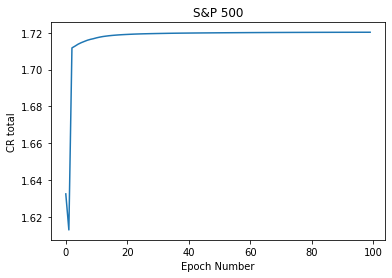

In [0]:
plt.plot(CRT_)
plt.xlabel('Epoch Number')
plt.ylabel('CR total')
plt.title("S&P 500")
plt.show()

In [0]:
test_spx=test(x_test,theta_spx,delta,mu)
print("Cumulative Reward Total S&P 500 for the test dataset {0}".format(test_spx))

Cumulative Reward Total S&P 500 for the test dataset 0.912898219707127


***CAC 40***

In [0]:
x = np.array(cac_r)
n_train = np.int(len(x)*0.7)
x_train=x[0:n_train]
x_test=x[n_train:]

In [0]:
theta_cac, CRT_ = train(x_train,theta_coeff=1,drawdown=False,epochs=100, M=xpast, learning_rate=learning_rate,delta=delta, mu=mu, eta=eta)

finished training


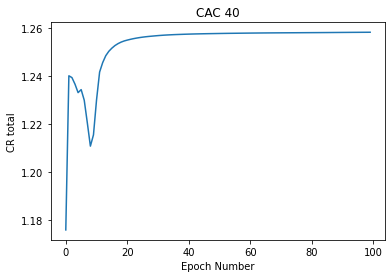

In [0]:
plt.plot(CRT_)
plt.xlabel('Epoch Number')
plt.ylabel('CR total')
plt.title("CAC 40")
plt.show()

In [0]:
test_cac=test(x_test,theta_cac,delta,mu)
print("Cumulative Reward Total CAC 40 for the test dataset {0}".format(test_cac))

Cumulative Reward Total CAC 40 for the test dataset 0.27443706203897744


***Nasdaq Composite***

In [0]:
x = np.array(nasdaq_r)
n_train = np.int(len(x)*0.7)
x_train=x[0:n_train]
x_test=x[n_train:]

In [0]:
theta_nasdaq, CRT_ = train(x_train,drawdown=False,epochs=100, M=xpast, learning_rate=learning_rate,delta=delta, mu=mu, eta=eta)

finished training


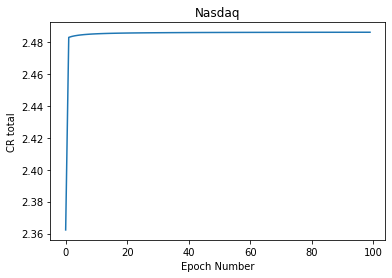

In [0]:
plt.plot(CRT_)
plt.xlabel('Epoch Number')
plt.ylabel('CR total')
plt.title("Nasdaq")
plt.show()

In [0]:
test_nasdaq=test(x_test,theta_nasdaq,delta,mu)
print("Cumulative Reward Total Nasdaq for the test dataset {0}".format(test_nasdaq))

Cumulative Reward Total Nasdaq for the test dataset 1.3547178502951607


***Dow Jones Industrials***

In [0]:
x = np.array(dj_r)
n_train = np.int(len(x)*0.7)
x_train=x[0:n_train]
x_test=x[n_train:]

In [0]:
theta_dj, CRT_ = train(x_train,theta_coeff=1,drawdown=False,epochs=100, M=xpast, learning_rate=learning_rate,delta=delta, mu=mu, eta=eta)

finished training


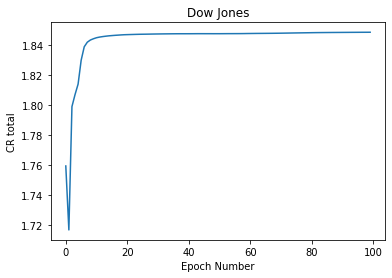

In [0]:
plt.plot(CRT_)
plt.xlabel('Epoch Number')
plt.ylabel('CR total')
plt.title('Dow Jones')
plt.show()

In [0]:
test_dj=test(x_test,theta_dj,delta,mu)
print("Cumulative Reward Total Dow Jones for the test dataset {0}".format(test_dj))

Cumulative Reward Total Dow Jones for the test dataset 0.791561962287231


###2. Using the management for drawdown-like phenomenon

***S&P 500***

In [0]:
x = np.array(spx_r)
n_train = np.int(len(x)*0.7)
x_train=x[0:n_train]
x_test=x[n_train:]

In [0]:
theta_spx_dd, CRT_ = train(x_train,drawdown=True,epochs=30, M=xpast, learning_rate=learning_rate,delta=delta, mu=mu, eta=eta)

finished training


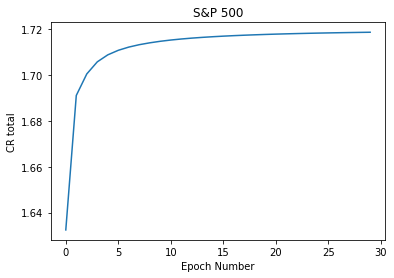

In [0]:
plt.plot(CRT_)
plt.xlabel('Epoch Number')
plt.ylabel('CR total')
plt.title("S&P 500")
plt.show()

In [0]:
test_spx_dd=test(x_test,theta_spx_dd,delta,mu)
print("Cumulative Reward Total S&P 500 for the test dataset {0}".format(test_spx_dd))

Cumulative Reward Total S&P 500 for the test dataset 0.912043167031074


***CAC 40***

In [0]:
x = np.array(cac_r)
n_train = np.int(len(x)*0.7)
x_train=x[0:n_train]
x_test=x[n_train:]

In [0]:
theta_cac_dd, CRT_ = train(x_train,drawdown=True,epochs=30, M=xpast, learning_rate=learning_rate,delta=delta, mu=mu, eta=eta)

finished training


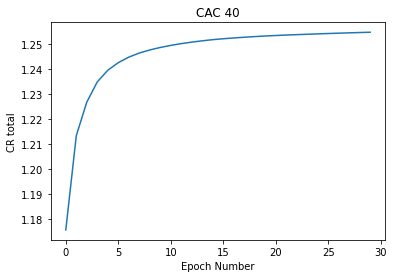

In [0]:
plt.plot(CRT_)
plt.xlabel('Epoch Number')
plt.ylabel('CR total')
plt.title("CAC 40")
plt.show()

In [0]:
test_cac_dd=test(x_test,theta_cac_dd,delta,mu)
print("Cumulative Reward Total CAC 40 for the test dataset {0}".format(test_cac_dd))

Cumulative Reward Total CAC 40 for the test dataset 0.2733620415500277


***Nasdaq Composite***

In [0]:
x = np.array(nasdaq_r)
n_train = np.int(len(x)*0.7)
x_train=x[0:n_train]
x_test=x[n_train:]

In [0]:
theta_nasdaq_dd, CRT_ = train(x_train,drawdown=True,epochs=30, M=xpast, learning_rate=learning_rate,delta=delta, mu=mu, eta=eta)

finished training


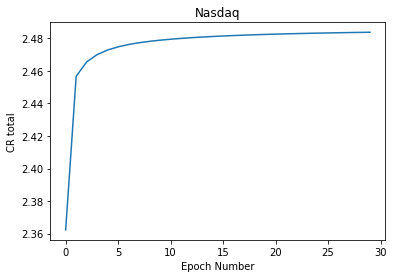

In [0]:
plt.plot(CRT_)
plt.xlabel('Epoch Number')
plt.ylabel('CR total')
plt.title("Nasdaq")
plt.show()

In [0]:
test_nasdaq_dd=test(x_test,theta_nasdaq_dd,delta,mu)
print("Cumulative Reward Total Nasdaq for the test dataset {0}".format(test_nasdaq_dd))

Cumulative Reward Total Nasdaq for the test dataset 1.3533029898996563


***Dow Jones Industrials***

In [0]:
x = np.array(dj_r)
n_train = np.int(len(x)*0.7)
x_train=x[0:n_train]
x_test=x[n_train:]

In [0]:
theta_dj_dd, CRT_ = train(x_train,drawdown=True,epochs=30, M=xpast, learning_rate=learning_rate,delta=delta, mu=mu, eta=eta)

finished training


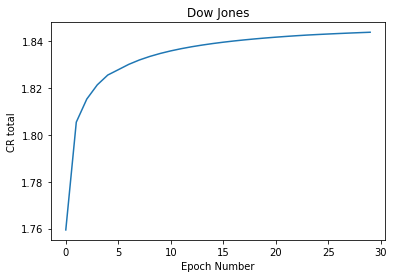

In [0]:
plt.plot(CRT_)
plt.xlabel('Epoch Number')
plt.ylabel('CR total')
plt.title('Dow Jones')
plt.show()

In [0]:
test_dj_dd=test(x_test,theta_dj_dd,delta,mu)
print("Cumulative Reward Total Dow Jones for the test dataset {0}".format(test_dj_dd))

Cumulative Reward Total Dow Jones for the test dataset 0.7896099801873918


## Comparisions

### Data

In [0]:
def get_price(security, start_date, end_date, freq):
    return yf.download(tickers = security, start = start_date, end = end_date, interval = freq)['Adj Close']

In [0]:
training_end='2015-12-31'
test_beginning='2019-01-01'
test_end='2020-01-01'

spx_train=get_price(security="^GSPC",start_date=None, end_date=training_end, freq='1D')
spx_test=get_price(security="^GSPC",start_date=test_beginning, end_date=test_end, freq='1D')

cac_train=get_price(security="^FCHI",start_date=None, end_date=training_end, freq='1D')
cac_test=get_price(security="^FCHI",start_date=test_beginning, end_date=test_end, freq='1D')

dj_train=get_price(security="^DJI",start_date=None, end_date=training_end, freq='1D')
dj_test=get_price(security="^DJI",start_date=test_beginning, end_date=test_end, freq='1D')

nasdaq_train=get_price(security="^IXIC",start_date=None, end_date=training_end, freq='1D')
nasdaq_test=get_price(security="^IXIC",start_date=test_beginning, end_date=test_end, freq='1D')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [0]:
spx_r_train=spx_train[1:] / spx_train[:-1].values- 1
spx_r_test=spx_test[1:] / spx_test[:-1].values- 1

cac_r_train=cac_train[1:] / cac_train[:-1].values- 1
cac_r_test=cac_test[1:] / cac_test[:-1].values- 1

dj_r_train=dj_train[1:] / dj_train[:-1].values- 1
dj_r_test=dj_test[1:] / dj_test[:-1].values- 1

nasdaq_r_train=nasdaq_train[1:] / nasdaq_train[:-1].values- 1
nasdaq_r_test=nasdaq_test[1:] / nasdaq_test[:-1].values- 1

In [0]:
theta_spx, CRT_ = train(spx_r_train,theta_coeff=1,drawdown=False,epochs=10, M=xpast, learning_rate=learning_rate,delta=delta, mu=mu, eta=eta)

finished training


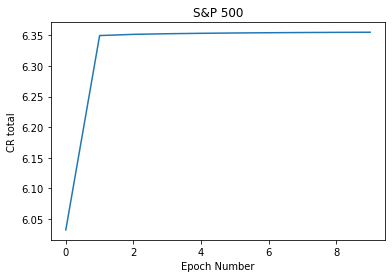

In [0]:
plt.plot(CRT_)
plt.xlabel('Epoch Number')
plt.ylabel('CR total')
plt.title("S&P 500")
plt.show()

In [0]:
test_spx=test(spx_r_test,theta_spx,delta,mu)
print("Cumulative Reward Total S&P 500 for the test dataset {0}".format(test_spx))

Cumulative Reward Total S&P 500 for the test dataset 0.5469915305660512


***CAC 40***

In [0]:
theta_cac, CRT_ = train(cac_r_train,theta_coeff=1,drawdown=False,epochs=10, M=xpast, learning_rate=learning_rate,delta=delta, mu=mu, eta=eta)

finished training


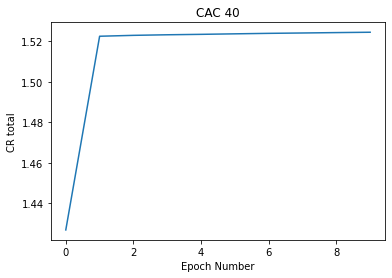

In [0]:
plt.plot(CRT_)
plt.xlabel('Epoch Number')
plt.ylabel('CR total')
plt.title("CAC 40")
plt.show()

In [0]:
test_cac=test(cac_r_test,theta_cac,delta,mu)
print("Cumulative Reward Total CAC 40 for the test dataset {0}".format(test_cac))

Cumulative Reward Total CAC 40 for the test dataset 0.36712227073326237


***Nasdaq Composite***

In [0]:
theta_nasdaq, CRT_ = train(nasdaq_r_train,drawdown=False,epochs=10, M=xpast, learning_rate=learning_rate,delta=delta, mu=mu, eta=eta)

finished training


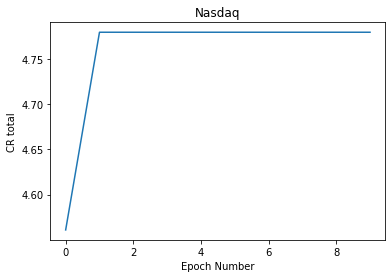

In [0]:
plt.plot(CRT_)
plt.xlabel('Epoch Number')
plt.ylabel('CR total')
plt.title("Nasdaq")
plt.show()

In [0]:
test_nasdaq=test(nasdaq_r_test,theta_nasdaq,delta,mu)
print("Cumulative Reward Total Nasdaq for the test dataset {0}".format(test_nasdaq))

Cumulative Reward Total Nasdaq for the test dataset 0.7097504819106252


***Dow Jones Industrials***

In [0]:
theta_dj, CRT_ = train(dj_r_train,theta_coeff=1,drawdown=False,epochs=10, M=xpast, learning_rate=learning_rate,delta=delta, mu=mu, eta=eta)

finished training


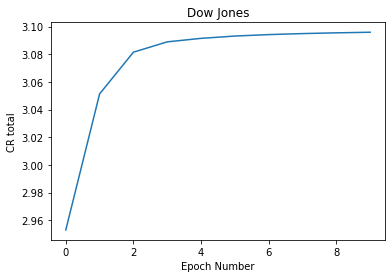

In [0]:
plt.plot(CRT_)
plt.xlabel('Epoch Number')
plt.ylabel('CR total')
plt.title('Dow Jones')
plt.show()

In [0]:
test_dj=test(dj_r_test,theta_dj,delta,mu)
print("Cumulative Reward Total Dow Jones for the test dataset {0}".format(test_dj))

Cumulative Reward Total Dow Jones for the test dataset 0.5838140648084735


### Evaluation function

In [0]:
def get_price(x, theta, mu):
  F, Fpos = positions(x, theta)
  T = len(x)
  ret = F * x
  cumret = (1 + np.array(ret)).cumprod() - 1
  price = mu*(1+cumret)
  return price

In [0]:
def return_annualized(price):
  ret = pd.DataFrame(price).pct_change()[1:]
  return np.mean(ret)*252

In [0]:
def vol_annualized(price):
  ret = pd.DataFrame(price).pct_change()[1:]
  return np.std(ret)*np.sqrt(252)

In [0]:
def sharpe_ratio(r,vol):
    return r/vol

In [0]:
def get_ratios(price):
    R=return_annualized(price)[0]
    vol_=vol_annualized(price)[0]
    sharpe_=sharpe_ratio(R,vol_)  
    return R,vol_,sharpe_

In [0]:
def plot_graphique(benchmark, portfolio, date_portofolio):
  fig = plt.figure(figsize=(20,10))
  fig.suptitle('Comparison Benchmark VS Portfolio prices', fontsize = 20)
  ax1 = plt.subplot(121)
  ax1.title.set_text('Benchmark')
  ax1.set_xlabel('Dates')
  ax1.set_ylabel('Price')
  plt.plot(benchmark.index, benchmark)
  ax2 = plt.subplot(122)
  ax2.title.set_text('Portfolio')
  ax2.set_xlabel('Dates')
  ax2.set_ylabel('Price')
  plt.plot(date_portofolio, portfolio)

In [0]:
def print_ratio(benchmark, portfolio):
  return_bench, vol_bench, sharpe_bench = get_ratios(benchmark)
  return_port, vol_port, sharpe_port = get_ratios(portfolio)
  result = pd.DataFrame(data = [[return_bench, return_port], 
                              [vol_bench, vol_port],
                              [sharpe_bench, sharpe_port]],
                     columns = ['Benchmark', 'Portfolio'],
                     index = ['Ret annualized', 'Vol annualized', 'Sharpe Ratio'])
  return result

In [0]:
def long_short_pos(x, theta):
    F,Fpos = positions(x, theta)
    pos=F[1:]-F[:-1]
    return np.sign(pos)

### Display


***S&P 500***

In [0]:
price_p_spx = get_price(spx_r_test, theta_spx, 1000)

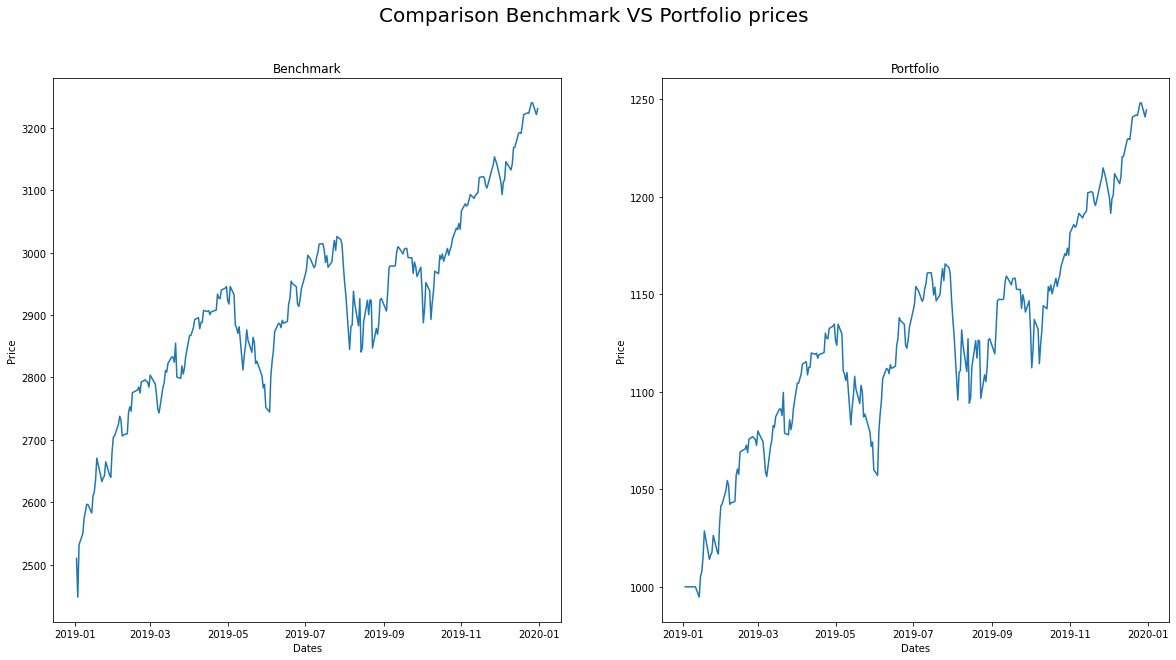

In [0]:
plot_graphique(spx_test, price_p_spx, spx_r_test.index)

Text(0.5, 1.0, 'Performance of Reccurent Reinforcement Learning')

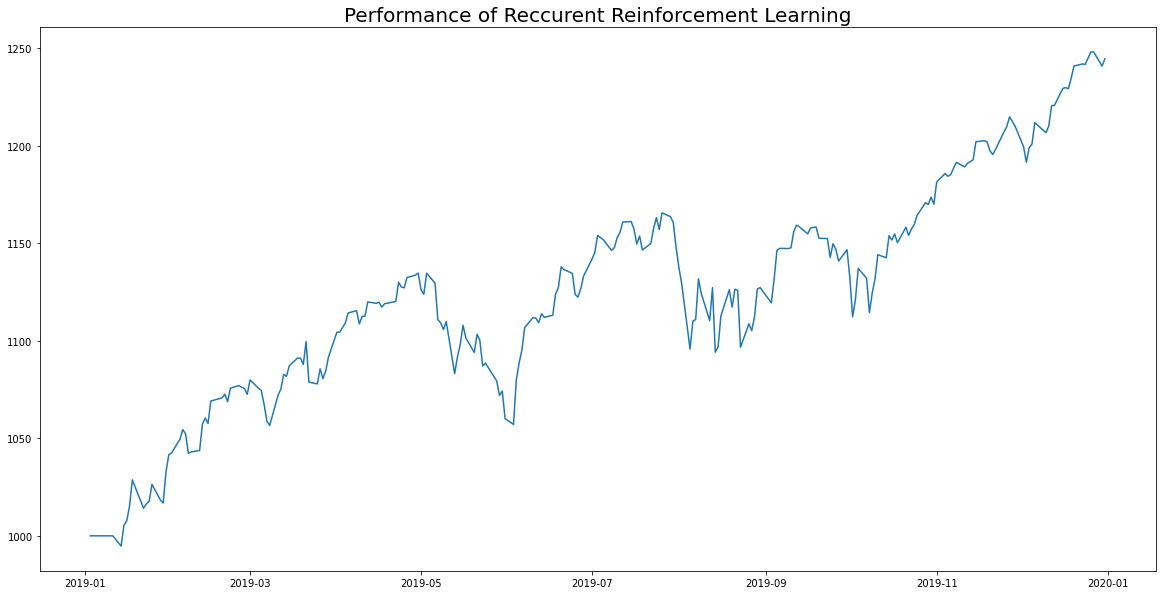

In [0]:
plt.figure(figsize=(20,10))
plt.plot(spx_r_test.index, price_p_spx)
plt.title("Performance of Reccurent Reinforcement Learning", fontsize = 20)

In [0]:
result_spx = print_ratio(spx_test, price_p_spx)
print(result_spx)

                Benchmark  Portfolio
Ret annualized   0.261357   0.227370
Vol annualized   0.124720   0.117032
Sharpe Ratio     2.095539   1.942811


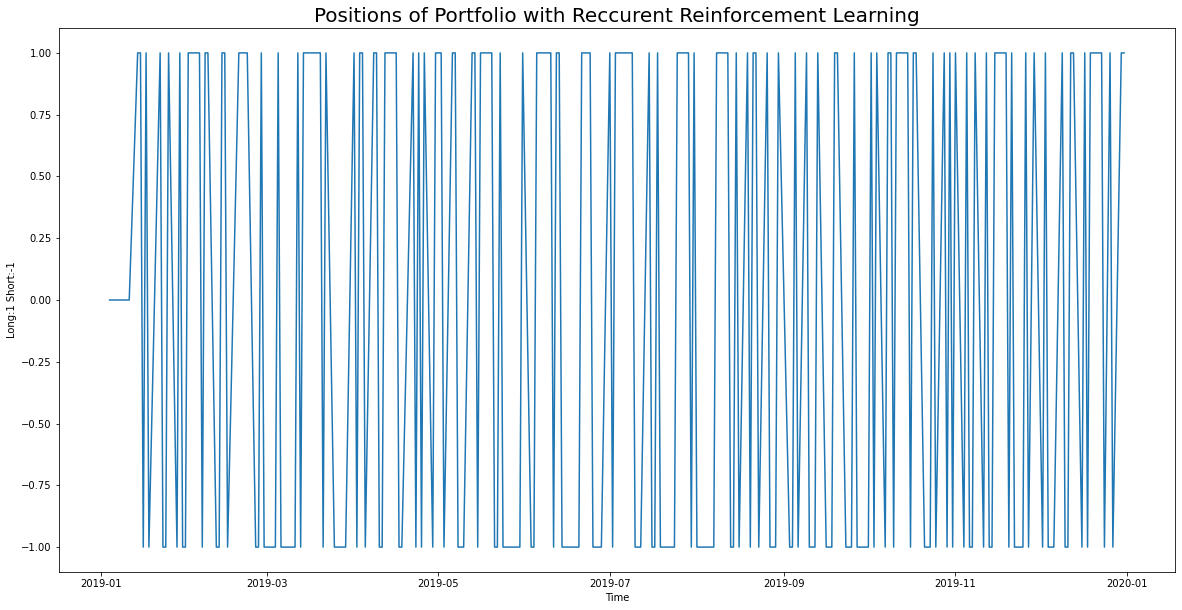

In [0]:
pos_spx=long_short_pos(spx_r_test,theta_spx)

plt.figure(figsize=(20,10))
plt.plot(spx_r_test.index[1:], pos_spx)
plt.xlabel('Time')
plt.ylabel("Long:1 Short:-1")
plt.title('Positions of Portfolio with Reccurent Reinforcement Learning', fontsize = 20)
plt.show()

***CAC 40***

In [0]:
price_p_cac = get_price(cac_r_test, theta_cac, 1000)

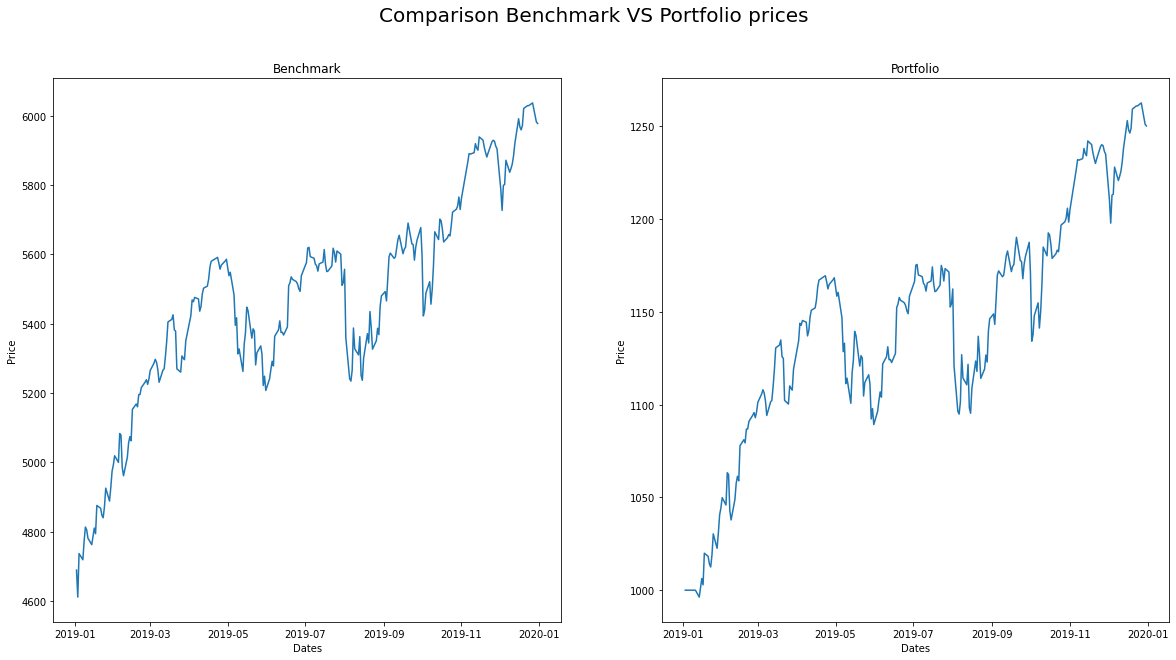

In [0]:
plot_graphique(cac_test, price_p_cac, cac_r_test.index)

In [0]:
result_cac = print_ratio(cac_test, price_p_cac)
print(result_cac)

                Benchmark  Portfolio
Ret annualized   0.249766   0.230707
Vol annualized   0.132235   0.127661
Sharpe Ratio     1.888803   1.807181


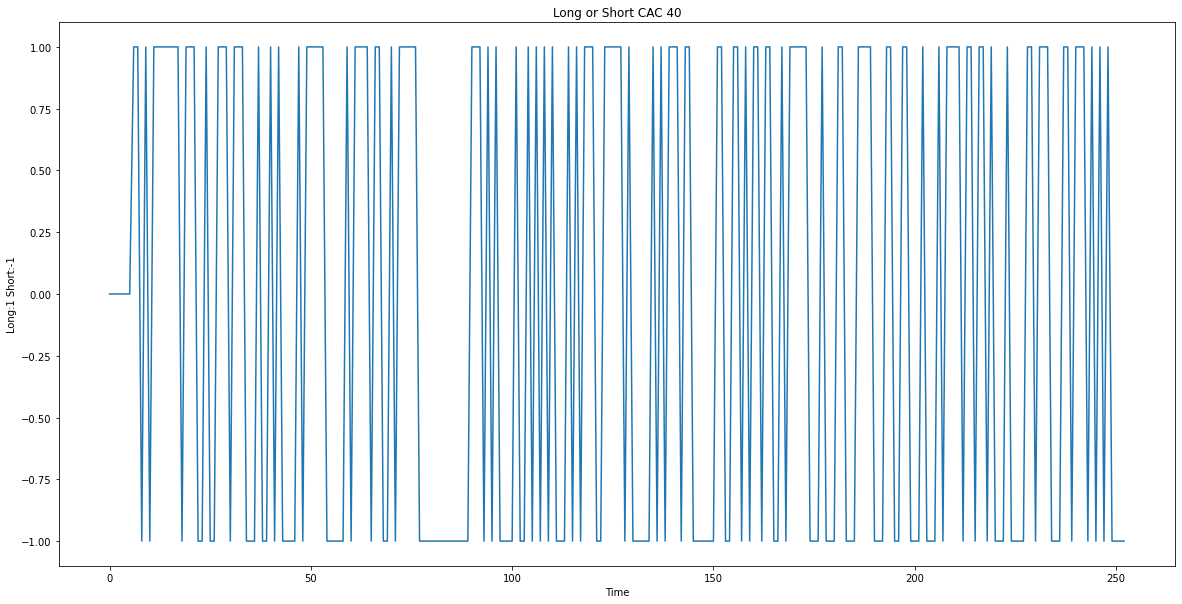

In [0]:
pos_cac=long_short_pos(cac_r_test,theta_cac)

plt.figure(figsize=(20,10))
plt.plot(pos_cac)
plt.xlabel('Time')
plt.ylabel("Long:1 Short:-1")
plt.title('Long or Short CAC 40')
plt.show()

***Nasdaq Composite***

In [0]:
price_p_nasdaq = get_price(nasdaq_r_test, theta_nasdaq, 1000)

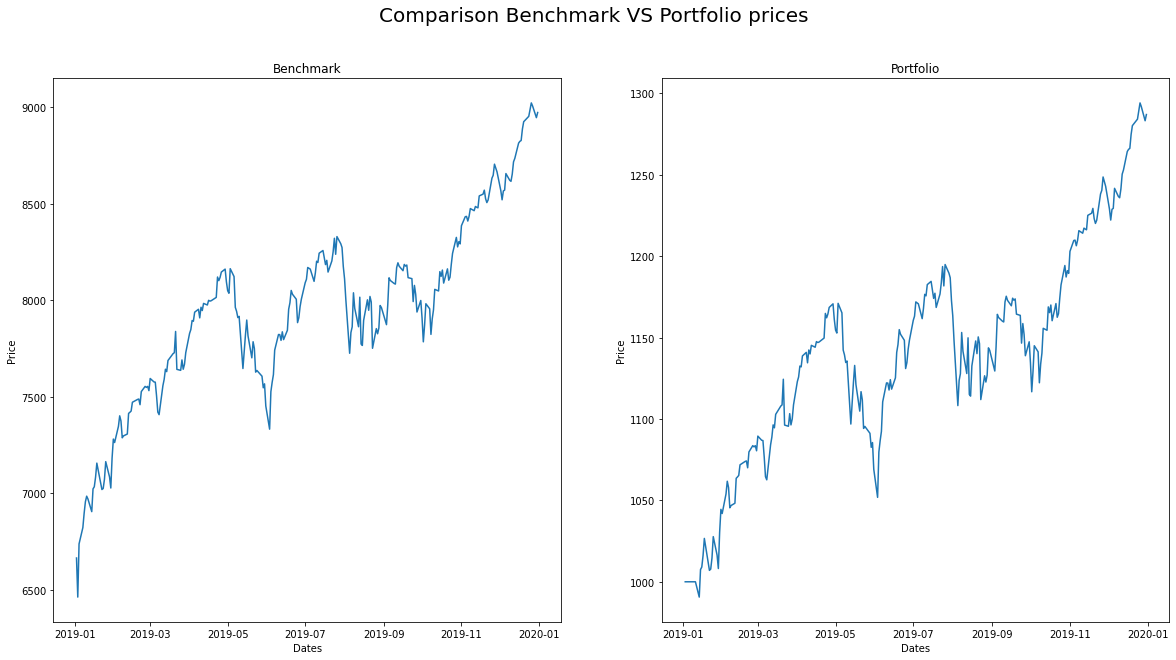

In [0]:
plot_graphique(nasdaq_test, price_p_nasdaq, nasdaq_r_test.index)

In [0]:
result_nasdaq = print_ratio(nasdaq_test, price_p_nasdaq)
print(result_nasdaq)

                Benchmark  Portfolio
Ret annualized   0.310805   0.265324
Vol annualized   0.156566   0.146911
Sharpe Ratio     1.985136   1.806013


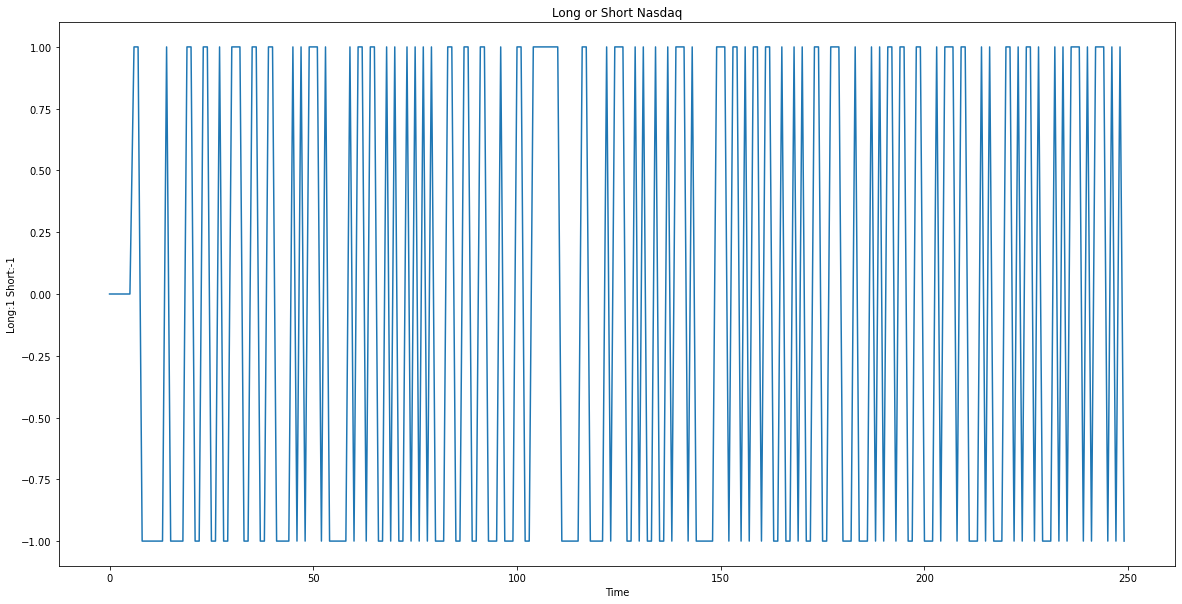

In [0]:
pos_nasdaq=long_short_pos(nasdaq_r_test,theta_nasdaq)

plt.figure(figsize=(20,10))
plt.plot(pos_nasdaq)
plt.xlabel('Time')
plt.ylabel("Long:1 Short:-1")
plt.title('Long or Short Nasdaq')
plt.show()

***Dow Jones Industrial***

In [0]:
price_p_dj = get_price(dj_r_test, theta_dj, 1000)

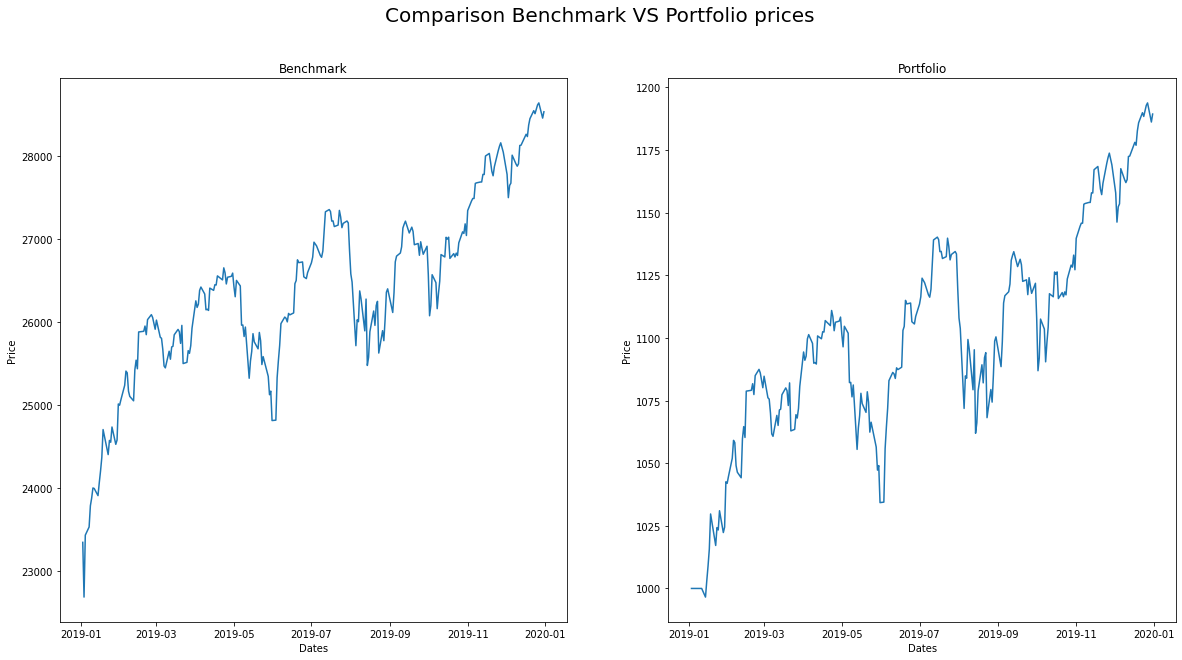

In [0]:
plot_graphique(dj_test, price_p_dj, dj_r_test.index)

In [0]:
result_dj = print_ratio(dj_test, price_p_dj)
print(result_dj)

                Benchmark  Portfolio
Ret annualized   0.209449   0.181576
Vol annualized   0.124363   0.116065
Sharpe Ratio     1.684174   1.564431


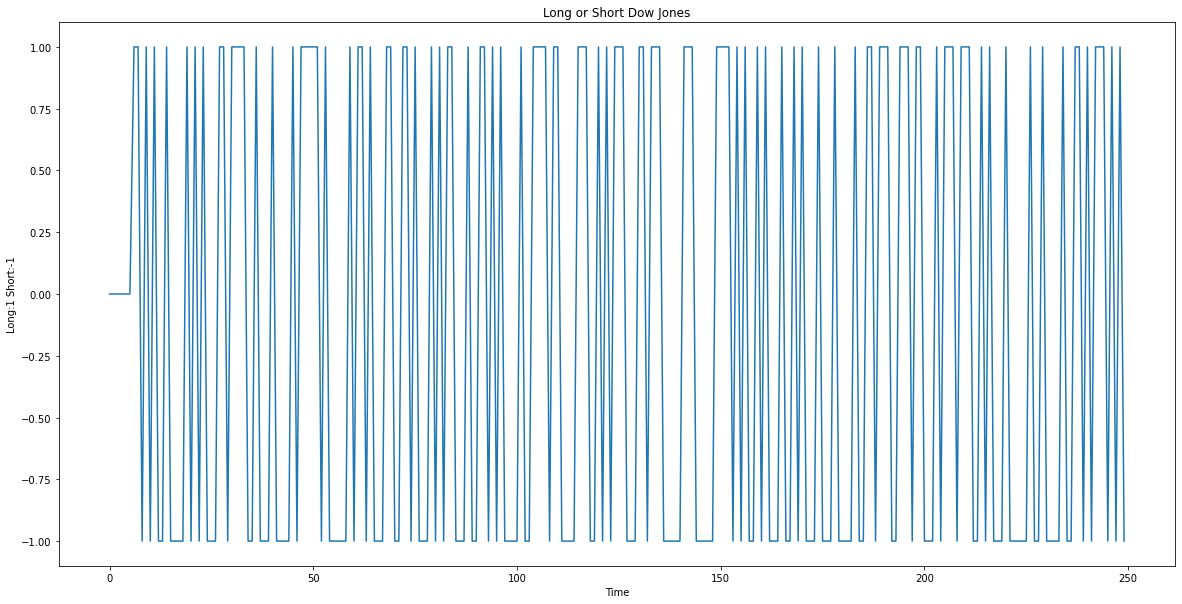

In [0]:
pos_dj=long_short_pos(dj_r_test,theta_dj)

plt.figure(figsize=(20,10))
plt.plot(pos_dj)
plt.xlabel('Time')
plt.ylabel("Long:1 Short:-1")
plt.title('Long or Short Dow Jones')
plt.show()